In [ ]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_data=pd.read_csv("train.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


,label
0,29720
1,2242


0s : 1s  ::   13.26 : 1


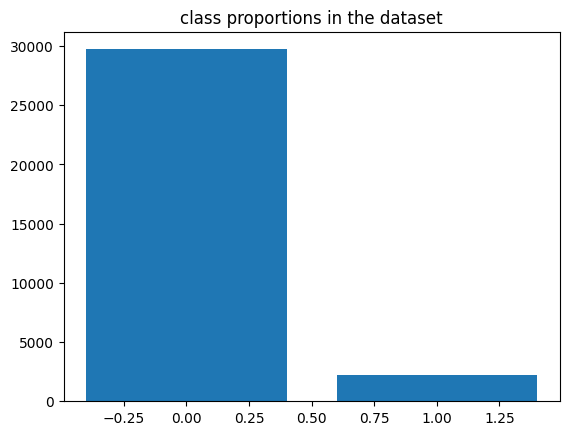

In [ ]:
#Check class distribution in dependent variable
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

,label
0,29720
1,6726


0s : 1s  ::   4.42 : 1


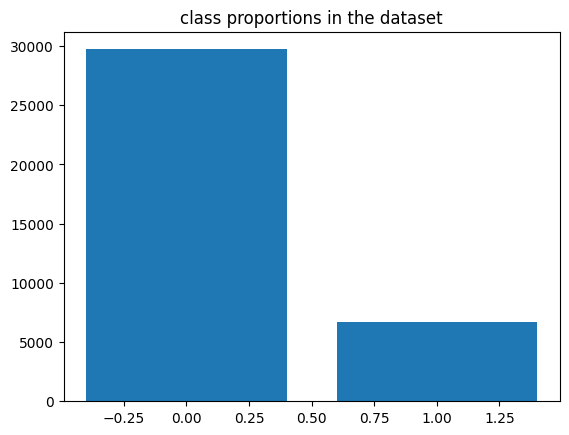

In [ ]:
#Balancing the dataset using Oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))])

    return text2.lower()

In [ ]:
#preprocess train dataset
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split()))

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [ ]:
#classes proportion in dependent variable in train and test dataset
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
0    23830
1     5326
Name: label, dtype: int64
29156
===========Test Data =========
0    5890
1    1400
Name: label, dtype: int64
7290


In [ ]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:23324
Class distributionCounter({0: 19063, 1: 4261})
Valid data len:5832
Class distributionCounter({0: 4767, 1: 1065})


In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)
#convert sentences to sequences of numbers
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:23324
Class distributionCounter({0: 19063, 1: 4261})
Validation data len:5832
Class distributionCounter({0: 4767, 1: 1065})
Test data len:7290
Class distributionCounter({0: 5890, 1: 1400})


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[  46 1076  513   36  147  125    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[ 230  323 1500 1747    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[   2 5328 4092 2426 2966  343 3298 4420 2267  915    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

In [ ]:
#model preparation
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))




model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            800016    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [ ]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
23/23 [==============================] - 12s 272ms/step - loss: 2.9643 - binary_accuracy: 0.7916 - val_loss: 1.5607 - val_binary_accuracy: 0.8174
Epoch 2/10
23/23 [==============================] - 7s 300ms/step - loss: 1.1119 - binary_accuracy: 0.8172 - val_loss: 0.7827 - val_binary_accuracy: 0.8174
Epoch 3/10
23/23 [==============================] - 6s 244ms/step - loss: 0.7185 - binary_accuracy: 0.8173 - val_loss: 0.6132 - val_binary_accuracy: 0.8174
Epoch 4/10
23/23 [==============================] - 7s 303ms/step - loss: 0.5914 - binary_accuracy: 0.8190 - val_loss: 0.4927 - val_binary_accuracy: 0.8565
Epoch 5/10
23/23 [==============================] - 15s 635ms/step - loss: 0.4787 - binary_accuracy: 0.8998 - val_loss: 0.3855 - val_binary_accuracy: 0.9316
Epoch 6/10
23/23 [==============================] - 12s 494ms/step - loss: 0.3901 - binary_accuracy: 0.9401 - val_loss: 0.3281 - val_binary_accuracy: 0.9491
Epoch 7/10
23/23 [==============================] - 12s 494ms

In [ ]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])


183/183 [==============================] - 2s 8ms/step
[[1.5833486e-05]
 [9.8006237e-01]
 [6.1016012e-06]
 [6.1630795e-05]
 [1.1247952e-05]
 [2.6497821e-05]
 [9.8855376e-01]
 [8.4782161e-02]
 [6.5220070e-06]
 [5.4120937e-06]]


228/228 [==============================] - 2s 8ms/step


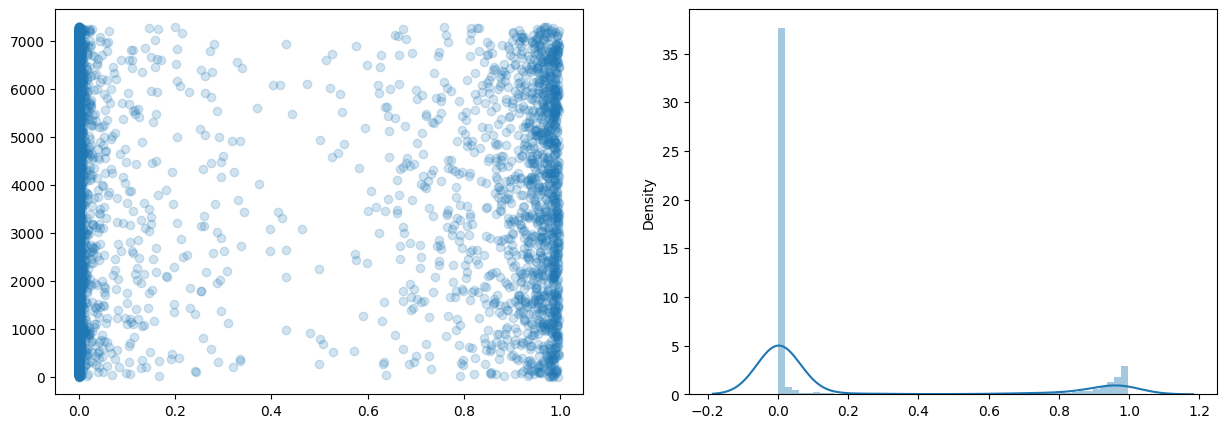

In [ ]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

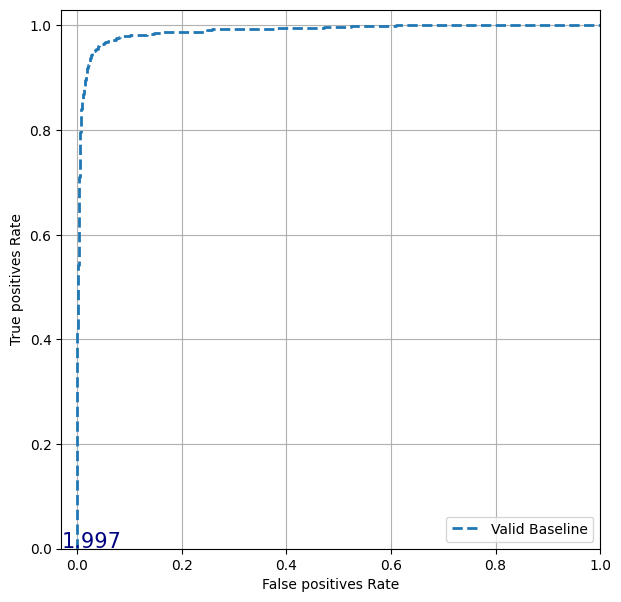

In [ ]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5890
           1       0.96      0.79      0.87      1400

    accuracy                           0.95      7290
   macro avg       0.95      0.89      0.92      7290
weighted avg       0.95      0.95      0.95      7290



In [ ]:
final_test=pd.read_csv("test.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[    2,  5328,  4092, ...,     0,     0,     0],
       [ 3806,   513,     6, ...,     0,     0,     0],
       [    2, 11416, 11417, ...,     0,     0,     0],
       ...,
       [    2,   535,     6, ...,     0,     0,     0],
       [  361,   745,    10, ...,     0,     0,     0],
       [  237,    51,     0, ...,     0,     0,     0]], dtype=int32)

array([[11131,     1,  4226, ...,     0,     0,     0],
       [    2,    64, 24442, ...,     0,     0,     0],
       [  576,   760,   845, ...,     0,     0,     0],
       ...,
       [  679,     1,    20, ...,     0,     0,     0],
       [    9,    34,   308, ...,     0,     0,     0],
       [  351,   805,   142, ...,     0,     0,     0]], dtype=int32)

538/538 [==============================] - 5s 10ms/step
[[4.1213105e-04]
 [8.9584953e-01]
 [2.9683926e-05]
 ...
 [5.7969708e-04]
 [8.7546886e-07]
 [2.8450193e-04]]


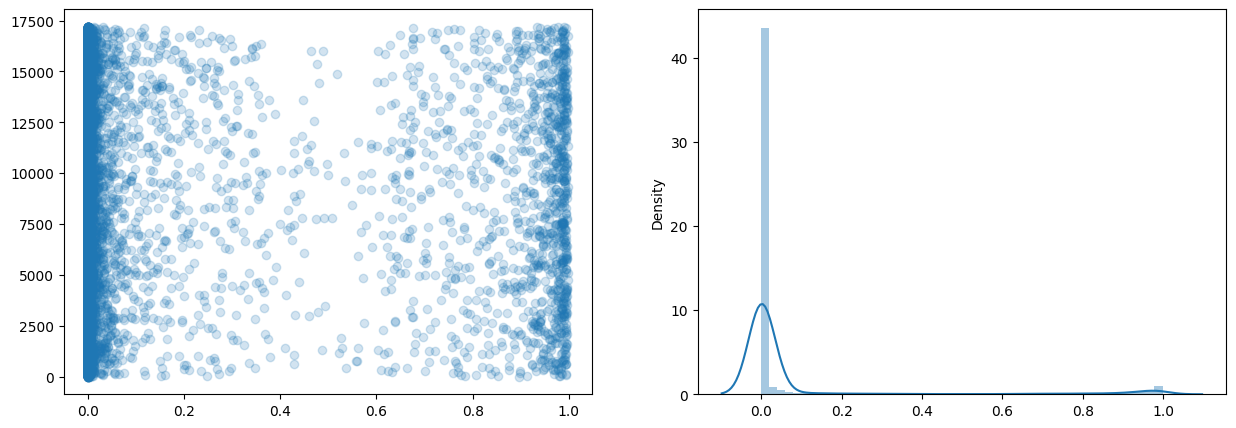

In [ ]:
#predict on actual test data
predictions = model.predict(f_test)
print(predictions)
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [ ]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
1,user white supremacists want everyone birdsâ movie hereâs,1.0
19,thought factory neutrality right wing fascism politics media brexit trump leadership,1.0
26,chick gets fucked hottest naked lady,1.0
33,suppo taiji fisherman bullying racism tweet4taiji thecove seashepherd,1.0
110,user ivanka bracelet feel good profiting from xenophobia misogyny hatred grabyourwallet,1.0
...,...,...
17128,user governmentâs antisemitism definition conflates with valid criticism israel opendemocracy,1.0
17148,grew fucked upð¤ fucked upð¥ believing better place fucking upð© âï¸,1.0
17176,user user most racist ever,1.0
17188,black professor demonizes proposes nazi style confiscation white assets like 1930s germany breaking,1.0


In [ ]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

,id,tweet
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
19,31982,thought factory: bbc neutrality on right wing fascism #politics #media #blm #brexit #trump #leadership &gt;3
26,31989,chick gets fucked hottest naked lady
33,31996,suppo the #taiji fisherman! no bullying! no racism! #tweet4taiji #thecove #seashepherd
110,32073,hey @user - a $14000 ivanka bracelet? do you feel good profiting from #xenophobia? #misogyny? #hatred? ? #grabyourwallet
...,...,...
17128,49091,@user the uk governmentâs new #anti-semitism definition conflates with valid criticism of #israel | opendemocracy
17148,49111,we grew up fucked upð¤ its fucked upð¥ i'm believing you in a better place but it's fucking me upð© Ã¨ âï¸
17176,49139,@user @user are the most racist pay ever!!!!!
17188,49151,"black professor demonizes, proposes nazi style confiscation of ""white"" assets; like 1930's germany #breaking"


In [ ]:
# Define the input text
input_text = input()

# Tokenize and preprocess the input text
input_text = remove_emoji(input_text)
input_text = clean_text(input_text)

# Convert the input text to a sequence of numbers
input_sequence = np.array(tokenizer.texts_to_sequences([input_text]))
input_sequence = pad_sequences(input_sequence, padding='post', maxlen=maxlen)

# Use the trained model to predict the sentiment of the input text
input_prediction = model.predict(input_sequence)
print(input_prediction)

# Map the prediction to "hate" or "not hate" based on a threshold (cutoff)
cutoff = 0.86  # You can adjust this threshold as needed
if input_prediction >= cutoff:
    result = "Hate"
else:
    result = "Not Hate"

# Print the result
print("Input text:", input_text)
print("Prediction:", result)


bitch asshole
1/1 [==============================] - 0s 28ms/step
[[0.05142156]]
Input text: bitch asshole
Prediction: Not Hate


In [ ]:
import pickle
pickle.dump(model,open('hate.pkl','wb'))
model = pickle.load(open('hate.pkl','rb'))

model.save("hate_ml_model.h5")
